<a href="https://colab.research.google.com/github/kusanele/Customer-Sales/blob/main/monthly_weekly_daily_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import datetime as dt

import xgboost as xgb
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error , mean_squared_error, r2_score

import seaborn as sns
color_pal = sns.color_palette()
import plotly.express as px



In [3]:
sales_pred = pd.read_csv("deb.csv")
sales_pred.head(3)

,TRANSACTION DATE,TRANSACTION MONTH,TRANSACTION TYPE,AGENT CODE,AGENT NAME,ORDER NO,UCR NUMBER,INVOICE NUMBER,INCOTERM,ATD (Sailing Date),...,FOREIGN CURRENCY,CURRENCY AMOUNT,ROE,HOME CURRENCY AMOUNT,ACCRUAL,Season,ORGANIZATION CODE,TRADER,INTAKE COUNTRY,TARGET REGION CODE
0,11/25/2022,11,Invoice,ROGR03,RIVERSIDE ORCHARDS,LO23TUL04196,2ZA01779148CDELLO23TUL04196M,IN2315338,EXW,12/12/2022,...,ZAR,332640.0,1.0,332640.0,NaN,2023,LO,IKARABELE,NaN,AFR
1,11/25/2022,11,Invoice,ROGR03,RIVERSIDE ORCHARDS,LO23TUL04200,2ZA01779148CDELLO23TUL04200M,IN2315339,EXW,11/21/2022,...,ZAR,120960.0,1.0,120960.0,NaN,2023,LO,IKARABELE,NaN,AFR
2,11/25/2022,11,Invoice,ROGR03,RIVERSIDE ORCHARDS,LO23TUL04203,2ZA01779148CDELLO23TUL04203M,IN2315340,EXW,11/21/2022,...,ZAR,211680.0,1.0,211680.0,NaN,2023,LO,IKARABELE,NaN,AFR


In [4]:
#Check for null values


In [5]:
sales_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42041 entries, 0 to 42040
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TRANSACTION DATE      42041 non-null  object 
 1   TRANSACTION MONTH     42041 non-null  int64  
 2   TRANSACTION TYPE      42041 non-null  object 
 3   AGENT CODE            42041 non-null  object 
 4   AGENT NAME            42041 non-null  object 
 5   ORDER NO              42038 non-null  object 
 6   UCR NUMBER            42037 non-null  object 
 7   INVOICE NUMBER        42041 non-null  object 
 8   INCOTERM              37063 non-null  object 
 9   ATD (Sailing Date)    42041 non-null  object 
 10  EXPORT WEEK           42041 non-null  int64  
 11  EXPORT MONTH          42041 non-null  int64  
 12  RECEIPT #             18449 non-null  object 
 13  REFERENCE #           23886 non-null  object 
 14  FOREIGN CURRENCY      42041 non-null  object 
 15  CURRENCY AMOUNT    

In [6]:
#drop other columns not needed for ml 

#sales_pred = sales_pred.drop(["name the columns you want to drop"], axis = 1)

#Overwrite the sales data Frame so we have only the information we need
predict_sales = sales_pred[["TRANSACTION DATE", "HOME CURRENCY AMOUNT"]].copy()
sales_pred.head(1)

,TRANSACTION DATE,TRANSACTION MONTH,TRANSACTION TYPE,AGENT CODE,AGENT NAME,ORDER NO,UCR NUMBER,INVOICE NUMBER,INCOTERM,ATD (Sailing Date),...,FOREIGN CURRENCY,CURRENCY AMOUNT,ROE,HOME CURRENCY AMOUNT,ACCRUAL,Season,ORGANIZATION CODE,TRADER,INTAKE COUNTRY,TARGET REGION CODE
0,11/25/2022,11,Invoice,ROGR03,RIVERSIDE ORCHARDS,LO23TUL04196,2ZA01779148CDELLO23TUL04196M,IN2315338,EXW,12/12/2022,...,ZAR,332640.0,1.0,332640.0,NaN,2023,LO,IKARABELE,NaN,AFR


In [7]:
predict_sales.head(1)

,TRANSACTION DATE,HOME CURRENCY AMOUNT
0,11/25/2022,332640.0


In [8]:
predict_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42041 entries, 0 to 42040
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TRANSACTION DATE      42041 non-null  object 
 1   HOME CURRENCY AMOUNT  42041 non-null  float64
dtypes: float64(1), object(1)
memory usage: 657.0+ KB


In [9]:
#Covert TRANSACTION DATE to datetime data type
predict_sales['TRANSACTION DATE'] = pd.to_datetime(predict_sales['TRANSACTION DATE'])


In [10]:
#sanity check
predict_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42041 entries, 0 to 42040
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   TRANSACTION DATE      42041 non-null  datetime64[ns]
 1   HOME CURRENCY AMOUNT  42041 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 657.0 KB


In [11]:
df_xgb = predict_sales.copy()

In [12]:
#Because we want to predict monthly sales, Convert date to month period

In [13]:
predict_sales["TRANSACTION DATE"] = predict_sales["TRANSACTION DATE"].dt.to_period("M")
monthly_income = predict_sales.groupby("TRANSACTION DATE").sum().reset_index()

In [14]:
#convert date to time stamp datatype

In [15]:
monthly_income["TRANSACTION DATE"] = monthly_income["TRANSACTION DATE"].dt.to_timestamp()

In [16]:
monthly_income.tail(2)

,TRANSACTION DATE,HOME CURRENCY AMOUNT
47,2023-01-01,12335101.54
48,2023-02-01,13568010.07


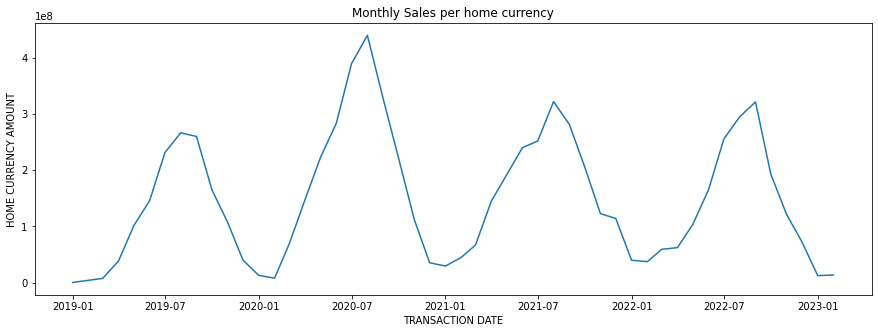

In [17]:
#Visualize the above

plt.figure(figsize = (15,5))
plt.plot(monthly_income["TRANSACTION DATE"], monthly_income["HOME CURRENCY AMOUNT"])
plt.xlabel("TRANSACTION DATE")
plt.ylabel("HOME CURRENCY AMOUNT")
plt.title("Monthly Sales per home currency")
plt.show()

In [18]:
#call the diference to make the home currency amount stationery

In [19]:
monthly_income["Sales_incr/decr(+-)"] = monthly_income["HOME CURRENCY AMOUNT"].diff()
monthly_income = monthly_income.dropna()
monthly_income.head()

,TRANSACTION DATE,HOME CURRENCY AMOUNT,Sales_incr/decr(+-)
1,2019-03-01,7.437938e+06,7229757.43
2,2019-04-01,3.847417e+07,31036235.23
3,2019-05-01,1.013867e+08,62912547.94
4,2019-06-01,1.458842e+08,44497473.82
5,2019-07-01,2.315043e+08,85620137.47


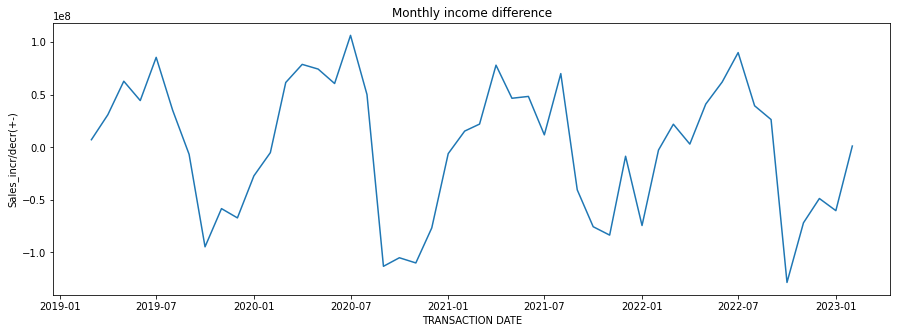

In [20]:
#Plot the above
plt.figure(figsize = (15,5))
plt.plot(monthly_income["TRANSACTION DATE"], monthly_income["Sales_incr/decr(+-)"])
plt.xlabel("TRANSACTION DATE")
plt.ylabel("Sales_incr/decr(+-)")
plt.title("Monthly income difference")
plt.show()

In [21]:
#Dropping off sales and data
supervised_data = monthly_income.drop(["TRANSACTION DATE", "HOME CURRENCY AMOUNT"], axis = 1)

In [22]:
#preparing supervised data

In [23]:
for i in range (1,13):
  col_name = "month_"+str(i)
  supervised_data[col_name] = supervised_data["Sales_incr/decr(+-)"].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head()

,Sales_incr/decr(+-),month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,6.168518e+07,-5057761.42,-27182468.15,-67151161.24,-58321132.90,-94672347.66,-6662704.82,35330750.58,85620137.47,44497473.82,62912547.94,31036235.23,7229757.43
1,7.891946e+07,61685176.31,-5057761.42,-27182468.15,-67151161.24,-58321132.90,-94672347.66,-6662704.82,35330750.58,85620137.47,44497473.82,62912547.94,31036235.23
2,7.445959e+07,78919456.62,61685176.31,-5057761.42,-27182468.15,-67151161.24,-58321132.90,-94672347.66,-6662704.82,35330750.58,85620137.47,44497473.82,62912547.94
3,6.071708e+07,74459585.33,78919456.62,61685176.31,-5057761.42,-27182468.15,-67151161.24,-58321132.90,-94672347.66,-6662704.82,35330750.58,85620137.47,44497473.82
4,1.065451e+08,60717083.07,74459585.33,78919456.62,61685176.31,-5057761.42,-27182468.15,-67151161.24,-58321132.90,-94672347.66,-6662704.82,35330750.58,85620137.47


Split data into train and test

In [24]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("train data shape", train_data.shape)
print("test data shape", test_data.shape)

train data shape (24, 13)
test data shape (12, 13)


min max scaler

In [25]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)

In [26]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

X_train shape (24, 12)
y_train shape (24,)
x_test shape (12, 12)
y_test shape (12,)


Make a prediction data frame to merge the predicted income of all trained algorithms

In [27]:
Income_dates = monthly_income["TRANSACTION DATE"][-12:].reset_index(drop=True)
#Income_dates = monthly_income["TRANSACTION DATE"][:24].reset_index(drop=True)
predict_df = pd.DataFrame(Income_dates)

In [28]:
#actual income in the last 12 months
actual_Income = monthly_income['HOME CURRENCY AMOUNT'][13:].to_list()
print(actual_Income)

[148392140.27, 222851725.6, 283568808.67, 390113891.72, 440317781.58, 327104413.93, 222029049.61, 112010258.53, 35336252.86, 29362459.51, 44812394.22, 66931288.0, 145098466.27, 191787355.88, 240219568.01, 252103423.04, 322256898.88, 281775787.47, 206227654.89, 122693965.7, 114198667.91, 39798842.61, 37186032.99, 59160491.11, 62249470.64, 103392866.59, 165596974.19, 255742635.52, 295275588.83, 321708631.84, 193134160.54, 121288976.32, 72591061.68, 12335101.540000001, 13568010.07]


**Forecast Sales using linear regression**

In [29]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_predict = lr_model.predict(x_test)

In [30]:
print("--------------------------------------------------------------------------------------------")

--------------------------------------------------------------------------------------------


In [31]:
# create a DataFrame with the next 12 months as the index
#next_12_months_df = pd.DataFrame(index=next_12_months)


In [32]:
# create additional features for the next 12 months using lagged values of the predicted sales
#for i in range(1, 12):
    #next_12_months_df[f'Predicted Sales Lag {i}'] = next_12_months_df['Predicted Sales'].shift(i)

In [33]:
# save the predicted sales to a CSV file
#next_12_months_df.to_csv('predicted_sales.csv')



In [34]:
# display the predicted sales for the next 12 months
#print(next_12_months_df)

In [35]:
#print("--------------------------------------------------------------------------------------------")

In [36]:
#reverse scalling
lr_predict = lr_predict.reshape(-1,1) 
#this is a set metrix - con tains the input features of the test data nad the predicted output
lr_predict_test_set = np.concatenate([lr_predict , x_test], axis = 1)
lr_predict_test_set = scaler.inverse_transform(lr_predict_test_set)

In [37]:
#calculate the predicted sales values

result_list = []
for index in range (0, len(lr_predict_test_set)):
  result_list.append(lr_predict_test_set[index][0] + actual_Income[index])
lr_predict_series = pd.Series(result_list, name = "linear Prediction")
predict_df = predict_df.merge(lr_predict_series, left_index = True , right_index = True)


In [38]:
print(predict_df)

   TRANSACTION DATE  linear Prediction
0        2022-03-01       1.764869e+08
1        2022-04-01       3.113808e+08
2        2022-05-01       3.017862e+08
3        2022-06-01       4.742630e+08
4        2022-07-01       4.803565e+08
5        2022-08-01       3.795257e+08
6        2022-09-01       2.049663e+08
7        2022-10-01       7.208569e+07
8        2022-11-01      -4.062744e+07
9        2022-12-01      -3.052279e+07
10       2023-01-01       1.862724e+07
11       2023-02-01       2.340074e+07


In [39]:
lr_mse = np.sqrt(mean_squared_error(predict_df["linear Prediction"], monthly_income['HOME CURRENCY AMOUNT'][-12:]))
lr_mae = mean_absolute_error(predict_df["linear Prediction"], monthly_income['HOME CURRENCY AMOUNT'][-12:])
lr_r2 = r2_score(predict_df["linear Prediction"], monthly_income['HOME CURRENCY AMOUNT'][-12:])

print("Linear Regression MSE:", lr_mse)
print("Linear Regression MAE:", lr_mae)
print("Linear Regression R2:", lr_r2)

Linear Regression MSE: 166654125.9652763
Linear Regression MAE: 141777253.77597436
Linear Regression R2: 0.16848470070980048


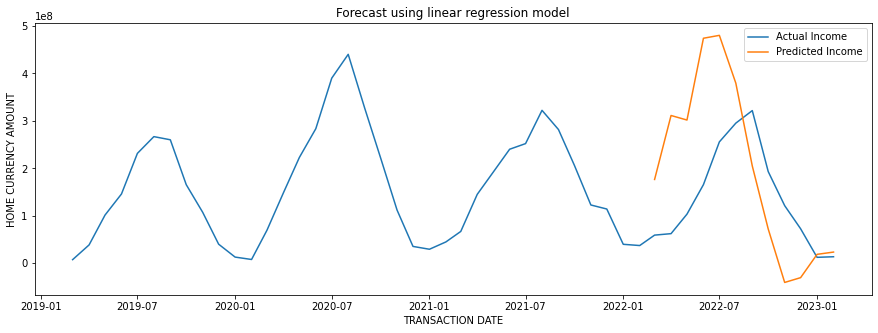

In [40]:
#Visualize predictions vs actual sales
plt.figure(figsize=(15,5))
#actual income
plt.plot(monthly_income["TRANSACTION DATE"],monthly_income['HOME CURRENCY AMOUNT'])

#predicted income

plt.plot(predict_df["TRANSACTION DATE"],predict_df["linear Prediction"])
plt.title("Forecast using linear regression model")
plt.xlabel("TRANSACTION DATE")
plt.ylabel("HOME CURRENCY AMOUNT")
plt.legend(["Actual Income", "Predicted Income"])
plt.show()


**Forecast Sales using XGB boost**

In [41]:
dfx = monthly_income[["TRANSACTION DATE","HOME CURRENCY AMOUNT"]].copy()

In [42]:
dfxplt = dfx.set_index('TRANSACTION DATE')
#dfx.index = pd.to_datetime(df_pred.index)
#sanity check
dfxplt.head(20)


,HOME CURRENCY AMOUNT
TRANSACTION DATE,
2019-03-01,7.437938e+06
2019-04-01,3.847417e+07
2019-05-01,1.013867e+08
2019-06-01,1.458842e+08
2019-07-01,2.315043e+08
2019-08-01,2.668351e+08
2019-09-01,2.601724e+08
2019-10-01,1.655000e+08
2019-11-01,1.071789e+08


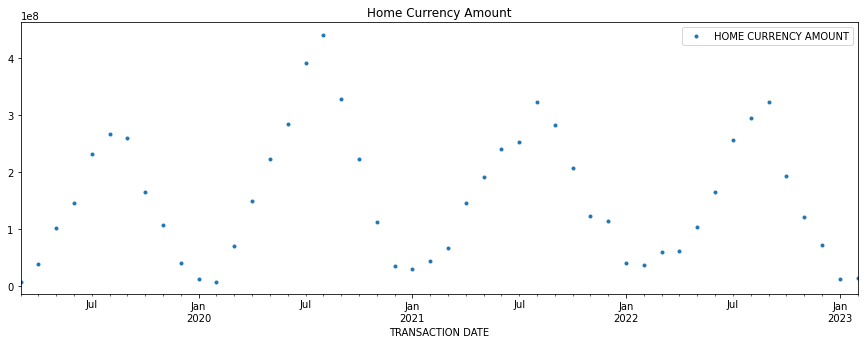

In [43]:
dfxplt.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Home Currency Amount')
plt.show()

**Train / Test Split**

In [44]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 1 to 48
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   TRANSACTION DATE      48 non-null     datetime64[ns]
 1   HOME CURRENCY AMOUNT  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


**Train**

In [45]:
train = dfx.loc[dfx["TRANSACTION DATE"] < '01-01-2022' ]

In [46]:
train.head(1)

,TRANSACTION DATE,HOME CURRENCY AMOUNT
1,2019-03-01,7437938.49


In [47]:
a= train.copy()
a["year"] = a["TRANSACTION DATE"].dt.year
a["month"] = a["TRANSACTION DATE"].dt.month
px.box(a, x="year", y="HOME CURRENCY AMOUNT" , color = "month", title = "Rate of Exchange")

**Test**

In [48]:
test = dfx.loc[dfx["TRANSACTION DATE"] > '01-01-2022' ]

In [49]:
test.head(1)

,TRANSACTION DATE,HOME CURRENCY AMOUNT
36,2022-02-01,37186032.99


In [50]:
test

,TRANSACTION DATE,HOME CURRENCY AMOUNT
36,2022-02-01,3.718603e+07
37,2022-03-01,5.916049e+07
38,2022-04-01,6.224947e+07
39,2022-05-01,1.033929e+08
40,2022-06-01,1.655970e+08
41,2022-07-01,2.557426e+08
42,2022-08-01,2.952756e+08
43,2022-09-01,3.217086e+08
44,2022-10-01,1.931342e+08
45,2022-11-01,1.212890e+08


In [51]:
b= test.copy()
b["year"] = b["TRANSACTION DATE"].dt.year
b["month"] = b["TRANSACTION DATE"].dt.month
px.box(b, x="year", y="HOME CURRENCY AMOUNT" , color = "month", title = "Rate of Exchange")

In [52]:
trs = train.set_index('TRANSACTION DATE')
trs.index = pd.to_datetime(trs.index)

In [53]:

tts = test.set_index('TRANSACTION DATE')
tts.index = pd.to_datetime(tts.index)


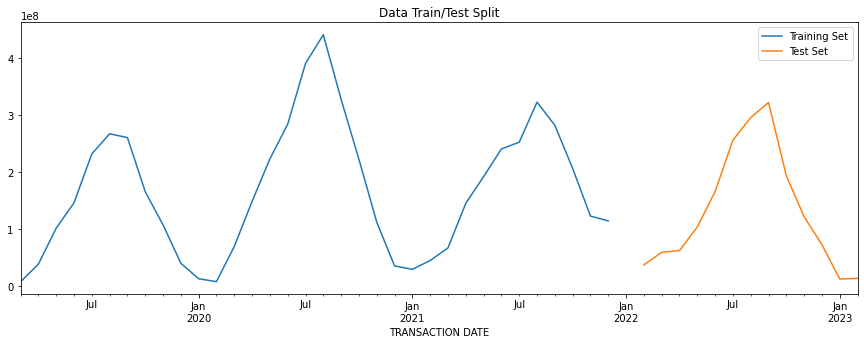

In [54]:

fig, ax = plt.subplots(figsize=(15, 5))
trs.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
tts.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2019', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

**Feature Creation**

In [55]:
def create_features(dfxplt):
    """
    Create time series features based on time series index.
    """
    dfxplt = dfxplt.copy()
    dfxplt['hour'] = dfxplt.index.hour
    dfxplt['dayofweek'] = dfxplt.index.dayofweek
    dfxplt['quarter'] = dfxplt.index.quarter
    dfxplt['month'] = dfxplt.index.month
    dfxplt['year'] = dfxplt.index.year
    dfxplt['dayofyear'] = dfxplt.index.dayofyear
    dfxplt['dayofmonth'] = dfxplt.index.day
    dfxplt['weekofyear'] = dfxplt.index.isocalendar().week
    return dfxplt

dfplt = create_features(dfxplt)

**Visualize our Feature / Target Relationship**




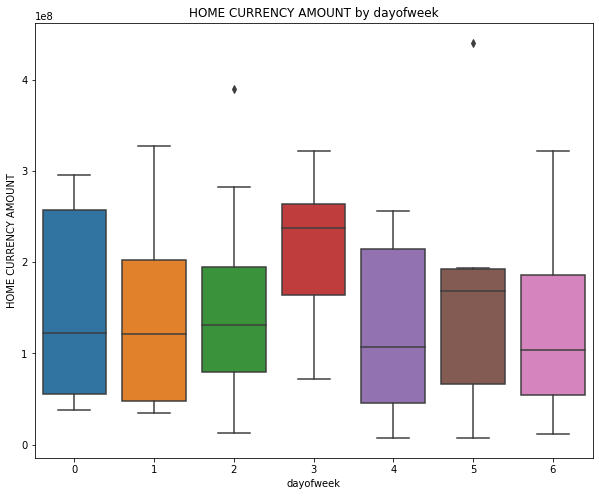

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=dfplt, x='dayofweek', y='HOME CURRENCY AMOUNT')
ax.set_title('HOME CURRENCY AMOUNT by dayofweek')
plt.show()

**Modeling**

In [57]:
train.head(1)
trs = train.set_index('TRANSACTION DATE')
trs.index = pd.to_datetime(trs.index)

In [58]:
tts.head(1)

,HOME CURRENCY AMOUNT
TRANSACTION DATE,
2022-02-01,37186032.99


In [59]:
trs.head(1)

,HOME CURRENCY AMOUNT
TRANSACTION DATE,
2019-03-01,7437938.49


In [60]:
train = create_features(trs)
test = create_features(tts)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'HOME CURRENCY AMOUNT'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [61]:
train.head(1)

,HOME CURRENCY AMOUNT,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
TRANSACTION DATE,,,,,,,,,
2019-03-01,7437938.49,0,4,1,3,2019,60,1,9


In [62]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[12:45:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:199722367.83136	validation_1-rmse:164951593.73598
[100]	validation_0-rmse:89494365.57015	validation_1-rmse:61672036.45810
[200]	validation_0-rmse:45251793.62267	validation_1-rmse:29910906.28558
[264]	validation_0-rmse:31851227.72824	validation_1-rmse:31797059.16840


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

**Feature Importance**

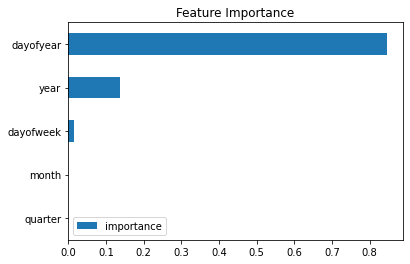

In [63]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

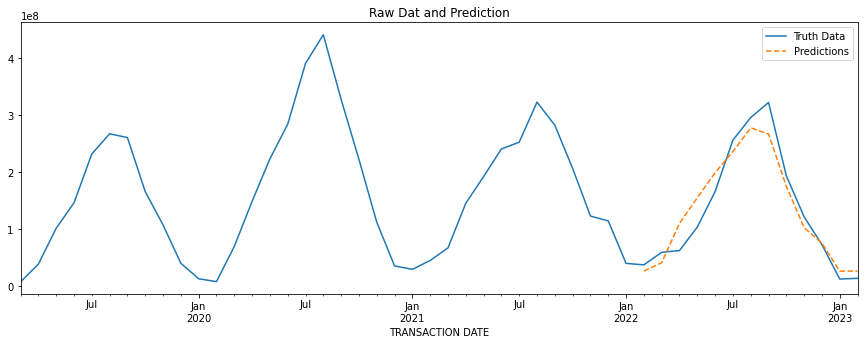

In [64]:
test['prediction'] = reg.predict(X_test)
dfplt = dfplt.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = dfplt[['HOME CURRENCY AMOUNT']].plot(figsize=(15, 5))
dfplt['prediction'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


**Score (RMSE)**

In [65]:
rmse_score = np.sqrt(mean_squared_error(test['HOME CURRENCY AMOUNT'], test['prediction']))
print(f'RMSE Score on Test set: {rmse_score:0.2f}')

RMSE Score on Test set: 29465133.11


**Error**

In [66]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-09-01    55292631.84
2022-05-01    51367533.41
2022-04-01    47656793.36
2022-06-01    33022337.81
2022-07-01    20032395.52
2022-11-01    18924272.32
2022-10-01    18268816.54
2022-03-01    18202731.11
2022-08-01    18063460.83
2023-01-01    13799512.46
Name: error, dtype: float64

## Monthly

**Predict home currency sales for the next 18 Months**

In [67]:
s_pred = pd.read_csv("test_set.csv")
s_pred.head()

,Date,dayofyear,dayofweek,quarter,month,year
0,3/31/2023,90,5,1,3,2023
1,4/30/2023,120,0,2,4,2023
2,5/31/2023,151,3,2,5,2023
3,6/30/2023,181,5,2,6,2023
4,7/31/2023,212,1,3,7,2023


In [68]:
s_pred.rename(columns={'Date': 'TRANSACTION DATE'}, inplace=True)
s_pred.head(2)

,TRANSACTION DATE,dayofyear,dayofweek,quarter,month,year
0,3/31/2023,90,5,1,3,2023
1,4/30/2023,120,0,2,4,2023


In [69]:
#s_pred = s_pred.set_index('TRANSACTION DATE')
#s_pred.index = pd.to_datetime(s_pred.index)
#s_pred.head(1)

In [70]:
train_set = s_pred[['dayofyear','dayofweek', 'quarter','month','year']].copy()

In [71]:
train_set.head()

,dayofyear,dayofweek,quarter,month,year
0,90,5,1,3,2023
1,120,0,2,4,2023
2,151,3,2,5,2023
3,181,5,2,6,2023
4,212,1,3,7,2023


In [72]:
y_pred = reg.predict(train_set)

In [73]:
# create a dataframe with the predicted sales for the next 18 months
y_pred

array([1.09906264e+08, 1.54760400e+08, 1.98619312e+08, 2.35710240e+08,
       2.77212128e+08, 2.66416000e+08, 1.74865344e+08, 1.02364704e+08,
       7.52162640e+07, 4.25769560e+07, 2.63652380e+07, 4.09577600e+07,
       8.44973840e+07, 1.54760400e+08, 1.98619312e+08, 2.35710240e+08,
       2.77212128e+08, 2.66416000e+08], dtype=float32)

In [74]:
s_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TRANSACTION DATE  18 non-null     object
 1   dayofyear         18 non-null     int64 
 2   dayofweek         18 non-null     int64 
 3   quarter           18 non-null     int64 
 4   month             18 non-null     int64 
 5   year              18 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 992.0+ bytes


In [75]:
s_pred['Predicted_Income'] = y_pred.tolist()

In [76]:
s_pred

,TRANSACTION DATE,dayofyear,dayofweek,quarter,month,year,Predicted_Income
0,3/31/2023,90,5,1,3,2023,109906264.0
1,4/30/2023,120,0,2,4,2023,154760400.0
2,5/31/2023,151,3,2,5,2023,198619312.0
3,6/30/2023,181,5,2,6,2023,235710240.0
4,7/31/2023,212,1,3,7,2023,277212128.0
5,8/31/2023,243,4,3,8,2023,266416000.0
6,9/30/2023,273,6,3,9,2023,174865344.0
7,10/31/2023,304,2,4,10,2023,102364704.0
8,11/30/2023,334,4,4,11,2023,75216264.0
9,12/31/2023,365,0,4,12,2023,42576956.0


In [77]:
s_pred.to_csv('Monthly_Prediction')

## Weekly

In [78]:
w_pred = pd.read_csv("data_2_weekly.csv")
w_pred.head()


,Date,dayofyear,dayofweek,quarter,month,year
0,2023/03/07,66,2,1,3,2023
1,2023/03/14,73,2,1,3,2023
2,2023/03/21,80,2,1,3,2023
3,2023/03/28,87,2,1,3,2023
4,2023/04/04,94,2,2,4,2023


In [79]:
w_pred.rename(columns={'Date': 'TRANSACTION DATE'}, inplace=True)
w_pred.head(2)

,TRANSACTION DATE,dayofyear,dayofweek,quarter,month,year
0,2023/03/07,66,2,1,3,2023
1,2023/03/14,73,2,1,3,2023


In [80]:
train_w = w_pred[['dayofyear','dayofweek', 'quarter','month','year']].copy()

In [81]:
train_w.head()

,dayofyear,dayofweek,quarter,month,year
0,66,2,1,3,2023
1,73,2,1,3,2023
2,80,2,1,3,2023
3,87,2,1,3,2023
4,94,2,2,4,2023


In [82]:
wy_pred = reg.predict(train_w)

In [83]:
# create a dataframe with the predicted sales for the next 18 months
wy_pred

array([7.18715120e+07, 7.18715120e+07, 1.09906264e+08, 1.09906264e+08,
       1.45803472e+08, 1.45803472e+08, 1.54760400e+08, 1.54760400e+08,
       1.98619312e+08, 1.98619312e+08, 1.98619312e+08, 1.98619312e+08,
       1.98619312e+08, 2.35710240e+08, 2.35710240e+08, 2.35710240e+08,
       2.35710240e+08, 2.77212128e+08, 2.77212128e+08, 2.77212128e+08,
       2.77212128e+08, 2.77212128e+08, 2.77212128e+08, 2.77212128e+08,
       2.66416000e+08, 2.66416000e+08, 2.66416000e+08, 2.66416000e+08,
       1.80289664e+08, 1.80289664e+08, 1.80289664e+08, 1.80289664e+08,
       1.02364704e+08, 1.02364704e+08, 1.02364704e+08, 1.02364704e+08,
       1.02364704e+08, 7.52162640e+07, 7.52162640e+07, 4.25769560e+07,
       4.25769560e+07, 4.25769560e+07, 4.25769560e+07, 2.63652380e+07,
       2.63652380e+07, 2.63652380e+07, 2.63652380e+07, 2.63652380e+07,
       2.63652380e+07, 2.63652380e+07, 4.09577600e+07, 4.09577600e+07,
       7.18715120e+07, 7.18715120e+07, 1.09906264e+08, 1.09906264e+08,
      

In [84]:
w_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TRANSACTION DATE  69 non-null     object
 1   dayofyear         69 non-null     int64 
 2   dayofweek         69 non-null     int64 
 3   quarter           69 non-null     int64 
 4   month             69 non-null     int64 
 5   year              69 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 3.4+ KB


In [85]:
w_pred['Predicted_Income'] = wy_pred.tolist()

In [86]:
w_pred

,TRANSACTION DATE,dayofyear,dayofweek,quarter,month,year,Predicted_Income
0,2023/03/07,66,2,1,3,2023,71871512.0
1,2023/03/14,73,2,1,3,2023,71871512.0
2,2023/03/21,80,2,1,3,2023,109906264.0
3,2023/03/28,87,2,1,3,2023,109906264.0
4,2023/04/04,94,2,2,4,2023,145803472.0
...,...,...,...,...,...,...,...
64,2024/05/28,149,2,2,5,2024,198619312.0
65,2024/06/04,156,2,2,6,2024,235710240.0
66,2024/06/11,163,2,2,6,2024,235710240.0
67,2024/06/18,170,2,2,6,2024,235710240.0


In [87]:
w_pred.to_csv('Weekly_Predictions')

## Daily 

In [88]:
d_pred = pd.read_csv("data_2_weekly.csv")
d_pred.head()


,Date,dayofyear,dayofweek,quarter,month,year
0,2023/03/07,66,2,1,3,2023
1,2023/03/14,73,2,1,3,2023
2,2023/03/21,80,2,1,3,2023
3,2023/03/28,87,2,1,3,2023
4,2023/04/04,94,2,2,4,2023


In [89]:
d_pred.rename(columns={'Date': 'TRANSACTION DATE'}, inplace=True)
d_pred.head(2)

,TRANSACTION DATE,dayofyear,dayofweek,quarter,month,year
0,2023/03/07,66,2,1,3,2023
1,2023/03/14,73,2,1,3,2023


In [90]:
train_d = d_pred[['dayofyear','dayofweek', 'quarter','month','year']].copy()

In [91]:
train_d.head()

,dayofyear,dayofweek,quarter,month,year
0,66,2,1,3,2023
1,73,2,1,3,2023
2,80,2,1,3,2023
3,87,2,1,3,2023
4,94,2,2,4,2023


In [92]:
dy_pred = reg.predict(train_d)

In [93]:
# create a dataframe with the predicted sales for the next 18 months
dy_pred

array([7.18715120e+07, 7.18715120e+07, 1.09906264e+08, 1.09906264e+08,
       1.45803472e+08, 1.45803472e+08, 1.54760400e+08, 1.54760400e+08,
       1.98619312e+08, 1.98619312e+08, 1.98619312e+08, 1.98619312e+08,
       1.98619312e+08, 2.35710240e+08, 2.35710240e+08, 2.35710240e+08,
       2.35710240e+08, 2.77212128e+08, 2.77212128e+08, 2.77212128e+08,
       2.77212128e+08, 2.77212128e+08, 2.77212128e+08, 2.77212128e+08,
       2.66416000e+08, 2.66416000e+08, 2.66416000e+08, 2.66416000e+08,
       1.80289664e+08, 1.80289664e+08, 1.80289664e+08, 1.80289664e+08,
       1.02364704e+08, 1.02364704e+08, 1.02364704e+08, 1.02364704e+08,
       1.02364704e+08, 7.52162640e+07, 7.52162640e+07, 4.25769560e+07,
       4.25769560e+07, 4.25769560e+07, 4.25769560e+07, 2.63652380e+07,
       2.63652380e+07, 2.63652380e+07, 2.63652380e+07, 2.63652380e+07,
       2.63652380e+07, 2.63652380e+07, 4.09577600e+07, 4.09577600e+07,
       7.18715120e+07, 7.18715120e+07, 1.09906264e+08, 1.09906264e+08,
      

In [94]:
d_pred['Predicted_Income'] = dy_pred.tolist()

In [95]:
d_pred

,TRANSACTION DATE,dayofyear,dayofweek,quarter,month,year,Predicted_Income
0,2023/03/07,66,2,1,3,2023,71871512.0
1,2023/03/14,73,2,1,3,2023,71871512.0
2,2023/03/21,80,2,1,3,2023,109906264.0
3,2023/03/28,87,2,1,3,2023,109906264.0
4,2023/04/04,94,2,2,4,2023,145803472.0
...,...,...,...,...,...,...,...
64,2024/05/28,149,2,2,5,2024,198619312.0
65,2024/06/04,156,2,2,6,2024,235710240.0
66,2024/06/11,163,2,2,6,2024,235710240.0
67,2024/06/18,170,2,2,6,2024,235710240.0


In [96]:
d_pred.to_csv('daily_Prediction')